# K-Nearest Neighbors on MNIST

## What is K-Nearest Neighbors? 

K-Nearest Neighbors is a non-parametric, lazy learning algorithm. K-Nearest Neighbors seperates data into several classes in order to predict the classification of a new sample point. By __non-parametric__, we mean that it makes no assumptions about the underlying data distribution, or in other words that the model structure is determined from the data. KNN is a __lazy learning algorithm__ because there is no explicit training phase, and that its training data is needed during the testing phase in order for KNN to generalize. 

![title](knn.png)

KNN relies on feature similarity, or how closely out-of-sample features resemble our training set. In the above picture, the new example will be classified as either a red triangle or blue square depending on how many nearest neighbors (k) we set. 

When k equals 1, the new example is classified to a blue square since the nearest neighbor is a blue square.

When k equals 3, the new example is classified to a red triangle since there are two red triangles and only one blue square.

When k equals 5, the circle is now enclosed to the first 5 datapoints that it reaches, which in this case will be 3 squares and 2 triangles. This means that the example will be classified as a square.

## KNN Applied to Digit Recognition

First, we'll import all necessary models and then load the dataset. We're primarily concerned with the 'data' and 'target' columns. 'data' contains 2d arrays, in which each element represents a greyscale codes from 0 to 255 at that specific pixel. 'target' represents labels for each of the 2d arrays.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, cache=True)

## What is MNIST?

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
mnist_df = pd.DataFrame(mnist.data, columns=mnist.feature_names)
mnist_df.insert(len(mnist_df.columns), 'target', mnist.target)
mnist_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [4]:
print(mnist_df['target'].value_counts())

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: target, dtype: int64


Next, we'll separate the arrays and the classes. The shape of x is 70000 by 784, meaning that there are 784 columns (one for each pixel of the 28x28 image) and 70000 rows these arrays. The shape of y is 70000 rows of numbers from 0 to 9.

In [5]:
X, y = mnist["data"], mnist["target"] 
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

We can fool around with matplotlib to visually give us an idea of what the array's greyscale numbers mean.

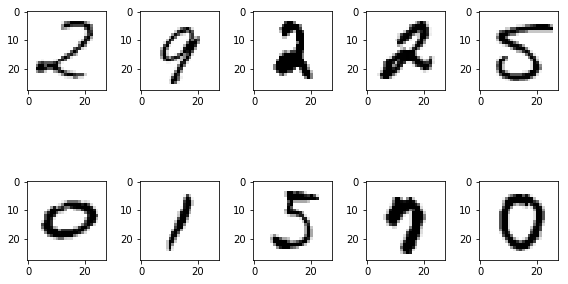

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[9]
some_digit_image = some_digit.reshape(28,28)
fig=plt.figure(figsize=(8, 8))
digits = X[np.random.randint(0, high=70000, size=10)]
rows = 2
columns = 5

for i in range(len(digits)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(digits[i].reshape(28,28), cmap=matplotlib.cm.binary,
              interpolation="nearest")
    plt.tight_layout()
plt.show()

## Our Data Visualized 

It's clearly infeasible to try visualizing our data since it's in a dimensionality we couldn't begin to fathom how to visualize. Our solution to this is __dimensionality reduction__. We can reduce the data from 784 dimensions to 2 dimensions using __t-Distributed Neighbor Stochastic Embedding__, or __t-SNE__ for short. t-SNE is an unsupervised, non-linear technique used for data exploration and visualizing high-dimensional data. Compared to __Principal Components Analysis__ (PCA), a linear dimensionality reduction technique, t-SNE can be used to visualize nonlinear datasets such as this swiss roll dataset.

![title](swissroll.png)

The solid line in the above graph represents t-SNE which preserves small pairwise distances or local similarities. The dotted line represents PCA which preserves large pairwise distances to maximize variance. What we can see from this is that PCA does not preserve the underlying structure of the dataset while t-SNE does. More information on the mathematics behind t-SNE will be linked below.

In [8]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(X[:7000])

reduced_df = np.vstack((tsne.T, y[:7000])).T
reduced_df = pd.DataFrame(data=reduced_df, columns=["X", "Y", "label"])
reduced_df.label = reduced_df.label.astype(np.int)

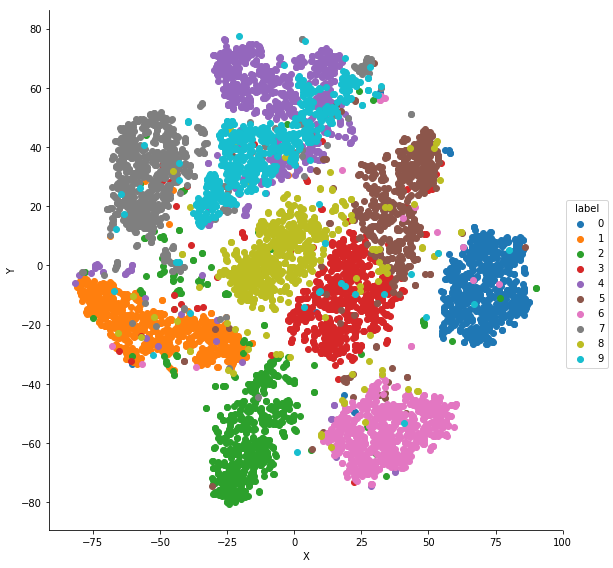

In [9]:
g = sns.FacetGrid(reduced_df, hue='label', size=8).map(plt.scatter, 'X', 'Y').add_legend()

What we can gather from this visualization are a couple things. For the most part, the digits are clustered separately quite well. Of course, there are some digits that fall into other clusters where they don't belong and this can be attributed to the poor handwriting of a certain digit (an 8 can look like a 6). Notably, there isn't much separation between 4s (purple) and 9s (teal) which shouldn't come as a big surprising considering the written similarity between a 4 and a 9.

## Creating Our Train/Test Split

Now that we are more familiar with our data, we can separate it into training and test sets. There are three datasets that a data scientist will generally interact with: a training set, a validation set, and a test set. We are primarily concerned with separating our data into a test and train split since we'll be using cross validation later. So what do each of these sets mean? The __training set__ is the sample of data that we fit our model to. Our model _learns_ from this data. The __validation set__ is the sample of data we use to evaluate our model on to fine-tune our __hyperparameters__, or the model parameters that we are able to explicitly change. Hyperparameters are not to be confused with __model parameters__, which are parameters that the ML algorithm will learn on its own, such as weights and biases in a linear regression model or split points in a decision tree. Finally, the __test set__ is the sample of data we wish to test our model on to provide an unbiased evaluation of our model fit on the training data. The model has _never_ seen the test set data before, and an __important__ note is that our test set should be stratified in the same way our training set is set up. It should contain a similar proportion of classes (digits 0 through 9) as our training set. A good rule of thumb is to separate our data into 80% train and 20% test.

![title](traintest.png)

X_train and y_train will be our training set consisting of 60000 instances, while X_test and y_test will be the remaining 10000. We'll then use np.random.permutation to shuffle the indices so that the numbers are not in order.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Training is as simple as creating a knn classifier with three neighbors required to classify and then calling knn.fit() to fit the classifier to the training set.

In [12]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

## Making Sure Our Model Generalizes Well

We can get an idea of how our model will generalize by using __k-fold cross validation__ with 5 folds (generally 10 folds is recommended, but for sake of compiling time we've reduced it to 5). Cross validation can be used to attain an understanding of how well our model will generalize to unseen data. We want to make sure that our model is low on bias and variance, or in other words is not respectively underfitting or overfitting but providing an overall good fit. We use cross validation because we want to avoid the problem of reducing the amount of training data since this risks losing important patterns/trends in the dataset, which would lead to a higher error.

k-fold cross validation works by dividing the training dataset into k partitions, or folds. Each of these folds are used as a validation set once and the other k-1 sets are used to form the training set, so by the end of cross validation the training set has been validated on k sets.

![title](crossval.png)

_An example of how 5-fold cross validation works iteratively_

In [13]:
cvs = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy")
print(cvs)
print(np.average(cvs))

NameError: name 'cvs' is not defined

Finally, we can test our model on the test set and see our accuracy. 97%, not bad!

In [14]:
knn.score(X_test, y_test)

0.9705

## Finding the Optimal Hyperparameters 

With each model data scientists use to solve a problem there exists a huge hyperparameter search space. It would be quite time consuming to hand-tune our hyperparemeters over and over again. This is where __grid search__ comes in, allowing us to search the hyperparameter space in a brute force fashion for the optimal hyperparameters. By the nature of grid search however, it is computationally complex on large datasets with large hyperparameter spaces. Therefore running grid search would be best done on a stratified subset of the training data. For the sake of time, we'll omit running the below code during the workshop.

In [ ]:
from sklearn.model_selection import GridSearchCV

# instantiate the grid
k_range = list(range(1, 5))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
#grid.fit(X_train, y_train)

# Support Vector Machine on MNIST

## What is a Support Vector Machine? 

A Support Vector Machine, or SVM, is a supervised learning algorithm that can be used for either classification or regression. The algorithm outputs a hyperplane which categorizes new examples. Given two classes, a SVM will find the hyperplane that maximizes the margin, or distance, between the nearest points of the two classes. This hyperplane is called the __maximum-margin hyperplane__. SVMs are ideal for high-dimensional data, are resilient to overfitting, and are very versatile.

![title](svm.png)

## The Kernel Trick 

While the hyperplanes above maximize the distance between the two classes, it's often the case that our data is not linearly separable, meaning that we cannot simply divide our classes with a linear hyperplane. For cases like this, we may translate our points into a higher dimensional space using the __kernel trick__ so that we may find a clear dividing margin. Without delving too deep into the mathematics behind the kernel trick, it works by calculating the inner products of the images between all pairs of data in the feature space. There are different kernels at our disposal, such as the polynomial kernel, the radial basis function kernel, and the sigmoid kernel to name a few.

![title](kernel.png)

## SVM Applied to Digit Recognition 

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = X_scaled[:10000], X_scaled[68000:], y[:10000], y[68000:]
shuffle_index = np.random.permutation(10000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [17]:
clf = SVC(kernel='poly', C=.001, gamma=10)

clf.fit(X_train, y_train)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
y_pred = clf.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[203,   0,   1,   0,   0,   0,   1,   1,   1,   0],
       [  0, 230,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0, 187,   0,   0,   1,   0,   2,   6,   0],
       [  0,   0,   1, 202,   0,   0,   0,   0,   3,   1],
       [  0,   1,   0,   0, 191,   0,   0,   0,   1,   1],
       [  2,   0,   0,   0,   0, 164,   1,   0,   2,   0],
       [  1,   0,   0,   1,   2,   2, 195,   0,   1,   0],
       [  0,   0,   5,   0,   0,   0,   0, 210,   0,   0],
       [  1,   0,   0,   0,   0,   7,   0,   0, 179,   0],
       [  0,   0,   0,   0,   5,   0,   0,   2,   0, 184]], dtype=int64)

In [38]:
clf.score(X_test, y_test)

0.9725

## Additional Reading 

t-SNE: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1